In [1]:
# Add description here
#
# *Note:* You can open this file as a notebook (JupyterLab: right-click on it in the side bar -> Open With -> Notebook)

In [2]:
# Uncomment the next two lines to enable auto reloading for imported modules
# %load_ext autoreload
# %autoreload 2
# For more info, see:
# https://docs.ploomber.io/en/latest/user-guide/faq_index.html#auto-reloading-code-in-jupyter

In [3]:
# If this task has dependencies, declare them in the YAML spec and leave this
# as None

import warnings

import numpy as np
import pandas as pd
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
)
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender

from hydro_timeseries.plotting import tsplot, get_windows
from hydro_timeseries.util import load_timeseries_csv, cv_evaluate

warnings.simplefilter("ignore", category=UserWarning)


upstream = None

# This is a placeholder, leave it as None
product = None

In [4]:
# Parameters
random_seed = 1
valid_from = "2021-11-01"
simulate_from = "2021-12-01"
upstream = {"run-tests": {"nb": "/home/m/repo/hydro-power-prediction/reports/run_tests.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/data_raw_tested.csv"}, "feature-manual": {"nb": "/home/m/repo/hydro-power-prediction/reports/feature_manual.ipynb", "data": "/home/m/repo/hydro-power-prediction/products/data/feature_manual.csv"}}
product = {"nb": "/home/m/repo/hydro-power-prediction/reports/exploratory_detrending.ipynb"}


In [5]:
data = load_timeseries_csv(upstream['run-tests']['data'])
data = data.dropna()

features=load_timeseries_csv(upstream['feature-manual']['data'])
arima_detrended = features['Value'] - features['arima_current']
arima_detrended = arima_detrended.dropna()
simulate_from = pd.to_datetime(simulate_from)
valid_from = pd.to_datetime(valid_from)

In [6]:
features = features.asfreq('15min')
features = features.dropna(axis=0)

In [7]:
'''
Daily
'''
daily = features.resample('D').mean()
X_daily = daily[daily.columns.difference(['Value'])]
y_daily = daily.Value

In [8]:
'''
hourly
'''
hourly = features.resample('h').mean()
X_hourly = hourly[hourly.columns.difference(['Value'])]
y_hourly = hourly.Value

In [9]:
'''
normal
'''
X = features[features.columns.difference(['Value'])].asfreq('15min')
y = data.Value.asfreq('15min')

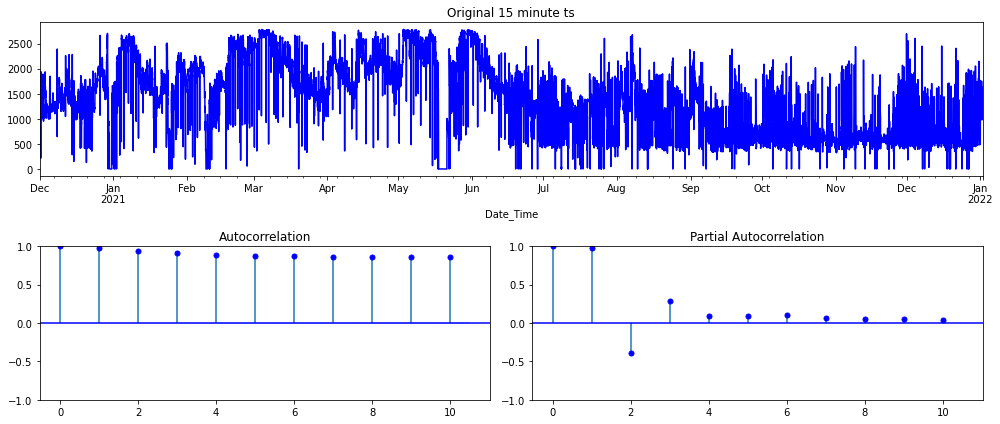

In [10]:
'''
Original ts
'''
tsplot(y, label='Original 15 minute ts')

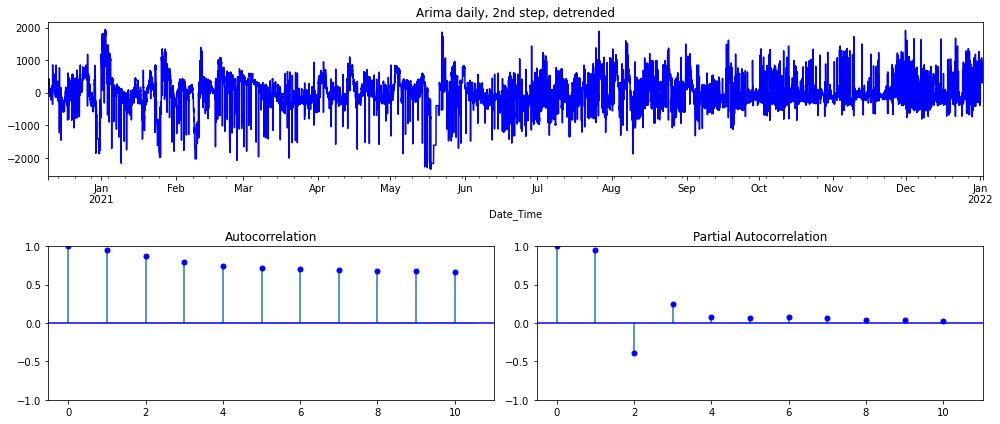

In [11]:
'''
Detrended with 2step daily arima.
-residual trend remains obvious from the changing mean, ACFs, PACFs
'''
tsplot(arima_detrended, label='Arima daily, 2nd step, detrended')

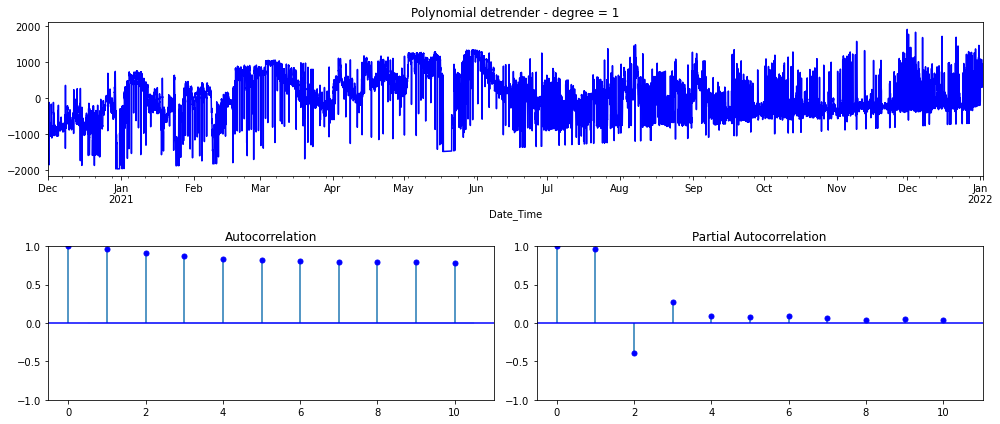

In [12]:
poly_transformer = Detrender(forecaster=PolynomialTrendForecaster(degree=1))
y_hat_poly = poly_transformer.fit_transform(y)
tsplot(y_hat_poly, label="Polynomial detrender - degree = 1")

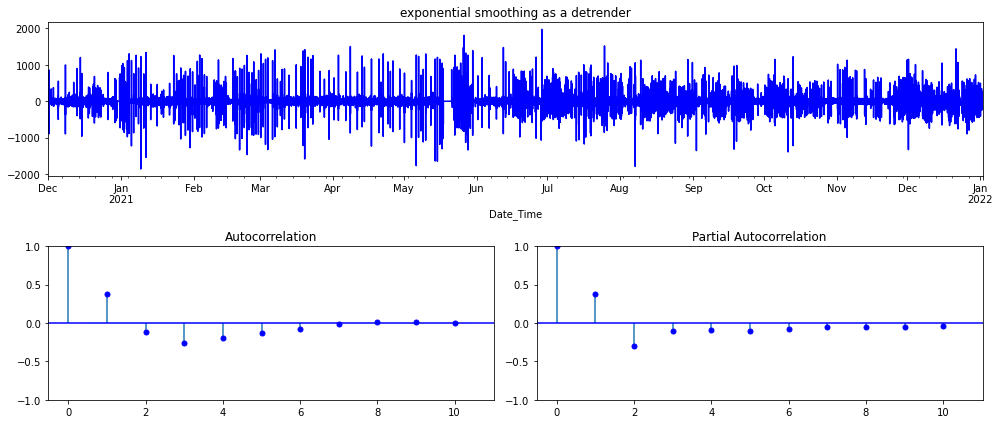

In [13]:
'''
Exponential smoothing
- additive trend
- no seasonality
'''
exp_smoother = ExponentialSmoothing(trend="add", damped_trend=True, remove_bias=True)
exp_transformer = Detrender(forecaster=exp_smoother)
y_hat_exp = exp_transformer.fit_transform(y)
tsplot(y_hat_exp, label="exponential smoothing as a detrender")

In [14]:
'''
Define forecast horizon for evaluation to be the 2nd day and step=96
- use expanding window CV with the forecast horizon
- the test window should represent one day, number of splits should be number of dates in the simulation dataset
'''
step = 96
fh = np.arange(97, 193)
cv = ExpandingWindowSplitter(initial_window=step*7, fh=fh, step_length=step)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(y, cv)
# plot_windows(y, train_windows, test_windows)

print(y[test_windows[-1]].index)

Number of Folds = 389
DatetimeIndex(['2022-01-01 00:00:00', '2022-01-01 00:15:00',
               '2022-01-01 00:30:00', '2022-01-01 00:45:00',
               '2022-01-01 01:00:00', '2022-01-01 01:15:00',
               '2022-01-01 01:30:00', '2022-01-01 01:45:00',
               '2022-01-01 02:00:00', '2022-01-01 02:15:00',
               '2022-01-01 02:30:00', '2022-01-01 02:45:00',
               '2022-01-01 03:00:00', '2022-01-01 03:15:00',
               '2022-01-01 03:30:00', '2022-01-01 03:45:00',
               '2022-01-01 04:00:00', '2022-01-01 04:15:00',
               '2022-01-01 04:30:00', '2022-01-01 04:45:00',
               '2022-01-01 05:00:00', '2022-01-01 05:15:00',
               '2022-01-01 05:30:00', '2022-01-01 05:45:00',
               '2022-01-01 06:00:00', '2022-01-01 06:15:00',
               '2022-01-01 06:30:00', '2022-01-01 06:45:00',
               '2022-01-01 07:00:00', '2022-01-01 07:15:00',
               '2022-01-01 07:30:00', '2022-01-01 07:45:00',
  

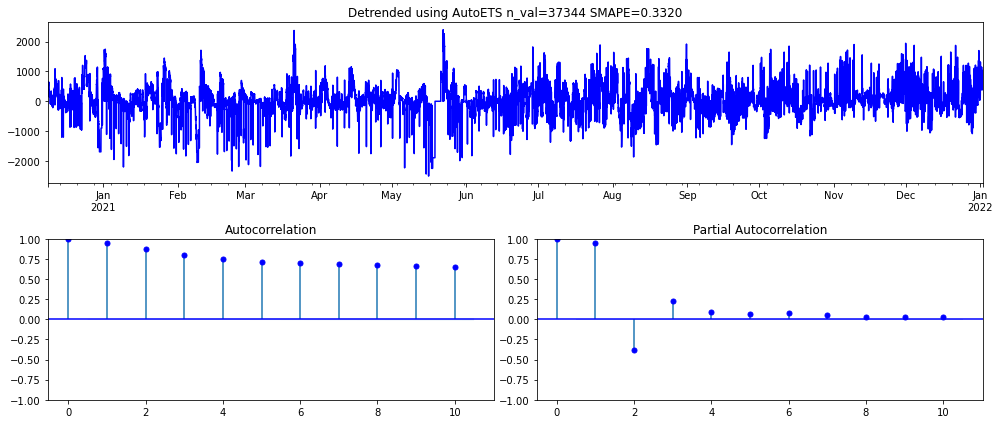

AutoETS as detrender n_val=37344 SMAPE=0.3320 RMSE=480.25 MAE=333.16


'\nets detrended = ADF Statistic: -13.914\narima detr = ADF Statistic: -12.023\n'

In [15]:
y_pred, y_test, smape_test, rmse_test, mae_test, df = cv_evaluate(forecaster=AutoETS(trend='add', damped_trend=True), y=y, cv=cv, X=None)

y_detrended = y_test - y_pred
tsplot(y_test - y_pred, label=f"Detrended using AutoETS n_val={len(y_pred)} SMAPE={smape_test:.4f}")
print(f"AutoETS as detrender n_val={len(y_pred)} SMAPE={smape_test:.4f} RMSE={rmse_test:.2f} MAE={mae_test:.2f}")

'''
ets detrended = ADF Statistic: -13.914
arima detr = ADF Statistic: -12.023
'''

# adfuller_test(value_detr, window=96)